# 5. Filtros IIR (Implementación)

A la hora de implementar un filtro IIR, un criterio de importancia para la elección de la estructura es el número de elementos de memoria y la sensibilidad a los efectos de palabra de longitud finita (cuantización de los coeficientes). Entre las estructuras con menor sensibilidad a los efectos de cuantización, tenemos las estructuras en **cascada** y **celosía**. 

Hay que tener presente que a diferencia con los filtros FIR, los cuales son muy poco sensibles a los efectos de longitud de palabra finita, la cuantización de los coeficientes de un filtro IIR trae como consecuencia una drástica re-ubicación de los polos y ceros del filtro, que a su vez modifican ostensiblemente la respuesta en la magnitud y fase, y pueden producir inestabilidades que no estaban presentes en el filtro digital de precisión infinita. Estos aspectos de la implementación en punto fijo de los filtros IIR serán expuestos en el Capítulo 6. En este capítulo se presentarán las características de las estructuras de implementación de filtros IIR asumiendo cálculos en precisión de punto flotante. 

## 5.1 Estructura Directa Tipo I

Este tipo de estructura es la más simple y poco eficiente. El algoritmo corresponde a una implementación directa de la ecuación en diferencias (ED) genérica de un filtro digital mostrada en el Capítulo 1, en la cual, la salida actual se calcula teniendo en cuenta los valores de las entrada actual, anteriores y salidas anteriores:

$$\sum_{k=0}^{P}a_{k}y[n-k]=\sum_{k=0}^{Q}b_{k}x[n-k]$$

despejando $y[n]$ se llega a:

$$y[n]=\sum_{k=0}^{Q}\frac{b_{k}}{a_{0}}x[n-k]-\sum_{k=1}^{P}\frac{a_{k}}{a_{0}}[n-k]$$

que implica que todos los coeficientes $a_k$ y $b_k$ están normalizados a $a_0$. Si el orden de dicha E.D. es $N = P = Q$, una forma estándar de representar esta ecuación es:

$$y[n] = \sum_{k=0}^{N}b_{k}x[n-k] - \sum_{k=1}^{N}a_{k}y[n-k]$$

En esta ecuación el número de elementos de memoria será $2N$, el número de multiplicaciones es $2N+1$ y el número de sumas $2N$, lo anterior puede verse más fácil en el diagrama de bloques mostrado a continuación. 

![Estructura directa Tipo I](../img/cap5_tipo1.png)

Nótese que en esta estructura, la ruta crítica que conduce a la máxima latencia del algoritmo corresponde al tiempo de propagación de una multiplicación y $N+1$ sumas.

Al igual que en la implementación de los filtros FIR, los índices $n$, $n-1$, $n-2$, representan la entrada/salida actual, el valor anterior y el anterior-anterior, respectivamente. Con estas asignaciones podemos construir un algoritmo orientado a muestras como el mostrado a continuación. En este algoritmo se ha asumido que todos los coeficientes $a_{k}$ y $b_{k}$ están normalizados a $a_{0}$. 

```C
#define Q 5
#define P 3

float x[Q], y[P]; 
float ak[P] = { 1.0, -0.013, 0.026 }; //a0 siempre es 1
float bk[Q] = { 0.5, 0.25, -0.13, 0.02, 0.01 }; 

void iniciar_filtro() { 
    int k; 
    //Fija condiciones iniciales a cero
    for(k=0; k<Q; k++) { x[k]=0; }
    for(k=0; k<P; k++) { y[k]=0; }
}

float filtrar(float x_ADC) { 
    int k; 
    float yn; 
    x[0] = x_ADC; 
    //Calcula la componente no recursiva de la E.D.
    yn = 0; 
    for(k=0; k<Q; k++) { 
        yn += bk[k] * x[k]; 
    }
    //Calcula la componente recursiva de la E.D.
    for(k=1; k<P; k++) {
        yn -= ak[k] * y[k]; 
    } 
    //Realiza la actualización del arreglo de entradas y salidas
    y[0]=yn;
    for(k=Q-1; k>=0; k--) { 
        x[k]=x[k-1]; 
    } 
    for(k=P-1; k>=0; k--) { 
        y[k]=y[k-1]; 
    }
    return yn;
}
```

Nótese que el valor de la salida actual ``yn`` solamente se calcula después de evaluar la sumatoria de la rama de entrada y la sumatoria de la rama de salida, lo cual corresponde a la ruta crítica.

En la práctica, esta estructura nunca se utiliza para realizar la implementación práctica. En su lugar se prefiere emplear la estructura directa tipo II que se explicará a continuación.

## 5.2 Estructura Directa Tipo II - Forma Canónica I

La principal ventaja de esta estructura es la reducción a la mitad del número de elementos de memoria. Podemos ver que la estructura directa tipo I, mostrada en la sección anterior, es la conexión en serie de dos sistemas LTI, uno de entrada todo ceros con coeficientes $b_{k}$ y uno de salida todo polos con coeficientes $a_{k}$. Recordemos que los sistemas LTI cumplen la propiedad conmutativa, por lo tanto, el diagrama de bloques puede reducirse a la forma mostrada en la siguiente figura, intercambiando el orden de los subsistemas de la estructura tipo I.

![Estructura directa Tipo I](../img/cap5_tipo2.png)

En esta nueva estructura, puede notarse que el número de sumas y multiplicaciones es el mismo de la tipo I, pero el número de elementos de memoria se ha reducido a $N$, ya que únicamente se deben almacenar los elementos del nodo $w[n]$ y no las entradas o salidas anteriores. Sin embargo, al igual que la tipo I, el cálculo de la salida solamente se consigue después de evaluar la sumatoria de la rama de entrada y la rama de salida. Por esta razón la ruta crítica está dada por 2 multiplicaciones y $N+1$ sumas

Las ecuaciones en diferencias de la nueva estructura son entonces: 

$$\begin{array}{r}
w[n]=x[n]-a_{1}w[n-1]-a_{2}w[n-2]-...-a_{N-1}w[n-(N-1)]\\
y[n]=b_{0}w[n]+b_{1}w[n-1]+b_{2}w[n-2]+...+b_{N-1}w[n-(N-1)]
\end{array}$$

A continuación se muestra el algoritmo orientado a muestras, en lenguaje C, para esta estructura.

```C
#define N 5 

float w[N];
float ak[N] = { 1, -2.5494, 3.2024, -2.0359, 0.6414 };
float bk[N] = { 0.0201, 0, -0.0402, 0, 0.0201 };

void iniciar_filtro() {
    int k;
    //Fija las condiciones iniciales a cero
    for (k=0; k<N; k++) {
        w[k] = 0.0;
    }
}

float filtrar(float x_ADC) { 
    int k;
    float yn, wn;

    wn = x_ADC;
    //Calcula el valor del elemento de retardo w[0]
    for(k=N-1; k>=1; k--) {
        wn -= ak[k] * w[k];
    }
    w[0]=wn;

    //Calcula la salida
    yn=0;
    for(k=0; k<N; k++) {
        yn += bk[k] * w[k];
    }
    //Realiza el movimiento de datos
    for(k=N-1; k>0; k--) {
        w[k]=w[k-1];
    }
    return yn;
}
```

En el programa anterior se asume que los coeficientes están en el código. Al igual que en los filtros FIR, es posible automatizar el proceso de creación del filtro y generación de un archivo de coeficientes para sustituir las primeras líneas del programa por ``#include "coeffs_iir.h"`` como se muestra a continuación.

Coeficientes ak: [  1.          -4.78451489  10.44504107 -13.45771989  11.12933104
  -6.0252604    2.0792738   -0.41721716   0.0372001 ]
Coeficientes bk: [  0.19287327  -1.5429862    5.40045169 -10.80090339  13.50112924
 -10.80090339   5.40045169  -1.5429862    0.19287327]


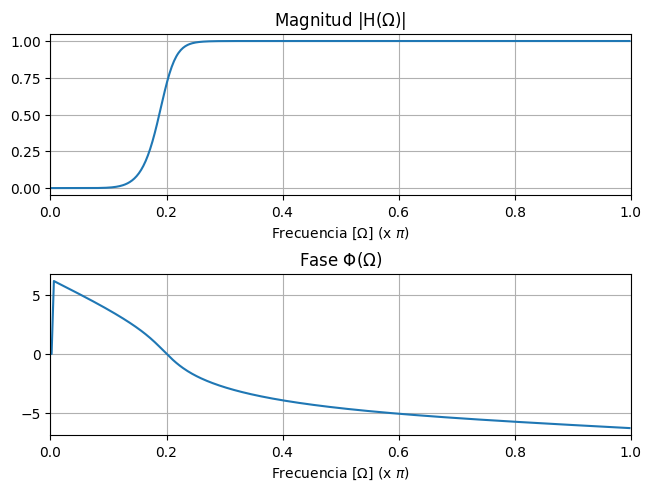

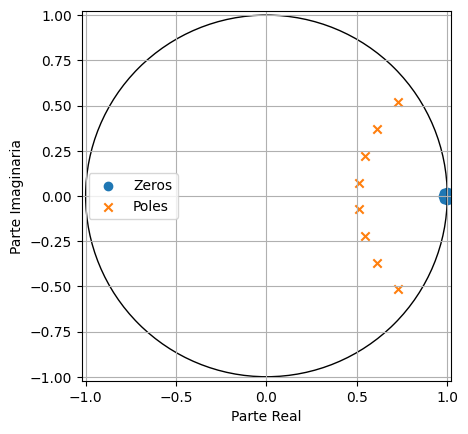

In [1]:
# Ejemplo 5.1. Cálculo de un filtro pasa-altos Butterworth de 8to orden y exportación de los coeficientes
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

bk,ak = sig.butter(8, 0.2, 'highpass')
print(f'Coeficientes ak: {ak}')
print(f'Coeficientes bk: {bk}')

# Grafica la respuesta en frecuencia
w, Hw = sig.freqz(bk,ak)
fig, axs = plt.subplots(2,1,layout='constrained')
axs[0].plot(w/np.pi, np.abs(Hw))
axs[0].set_xlabel(r'Frecuencia [$\Omega$] (x $\pi$)')
axs[0].set_title(r'Magnitud |H($\Omega$)|')
axs[0].set(xlim=(0,1))
axs[0].grid()
axs[1].plot(w/np.pi, np.unwrap(np.angle(Hw)))
axs[1].set_xlabel(r'Frecuencia [$\Omega$] (x $\pi$)')
axs[1].set_title(r'Fase $\Phi$($\Omega$)')
axs[1].set(xlim=(0,1))
axs[1].grid()
plt.show()

#Grafica la ubicación de polos y ceros
def zplane(sys):
    #Grafica la ubicación de polos y ceros
    fig, ax = plt.subplots()
    ax.scatter(sys.zeros.real, sys.zeros.imag, marker='o', label='Zeros')
    ax.scatter(sys.poles.real, sys.poles.imag, marker='x', label='Poles')
    ax.set_xlabel('Parte Real')
    ax.set_ylabel('Parte Imaginaria')
    ax.grid(True)
    ax.legend()
    #Superpone el círculo unitario
    unit_circle = plt.Circle((0, 0), 1 , fill = False)
    ax.set_aspect(1)
    ax.add_artist(unit_circle)
    maxv = np.max([np.max(np.abs(sys.zeros.real)), np.max(np.abs(sys.zeros.imag)), np.max(np.abs(sys.poles.real)), np.max(np.abs(sys.zeros.imag)), 1])
    ax.set(xlim=(-maxv,maxv), ylim=(-maxv,maxv))
    plt.show()

sys = sig.TransferFunction(bk, ak, dt=0.1)
zplane(sys)

#Exporta los coeficientes al archivo coeffs_iir.h
with open('coeffs_iir.h', 'w') as file:
    file.write(f'#define N {len(ak)}\n')
    file.write('const float ak[] = {\n')
    for sample in ak:
        file.write(f"\t {sample}, \n")
    file.write('};\n')
    file.write('const float bk[] = {\n')
    for sample in bk:
        file.write(f"\t {sample}, \n")
    file.write('};\n')
    file.close()

La implementación mostrada puede consultarse en el programa de referencia https://wokwi.com/projects/408470883234121729. Un aspecto importante a tener en cuenta, y que es común en los filtros IIR, es que los coeficientes $a_{k}$ son generalmente extremadamente pequeños comparados con los $b_{k}$, de allí que estos filtros sean muy sensibles a la implementación en punto fijo, debido a la pérdida de precisión de los $a_{k}$.

## 5.3 Estructura Directa Tipo III - Forma Canónica II

Las estructuras directa tipo I y tipo II tienen en común que la salida $y[n]$ solamente se calcula después de haber evaluado las sumatorias de la rama de entrada y la rama de salida. La principal característica de la estructura directa tipo III es que el valor de la salida es lo primero en calcularse, lo que permite escribir al DAC casi en forma inmediata después haber leído el ADC, de esta forma mientras se espera la nueva muestra de entrada, se pueden ir calculando las variables intermedias. En otras palabras, se reduce drásticamente la ruta crítica como se verá más adelante.

Esta estructura resulta como consecuencia de la notación en grafos de la estructura directa tipo II y la obtención de su versión transpuesta mediante el _teorema de inversión de grafos_, que establece que al invertir las direcciones de flujo de las transmitancias e intercambiando la entrada y la salida en el grafo, la función de transferencia permanecerá invariable. 

![Grafos en las estructura tipo II y III](../img/cap5_grafo_tipo23.png)

De allí que la estructura directa tipo III reciba también el nombre de **Transpuesta de la directa tipo II**. El diagrama de bloques resultante de esta transformación se muestra a continuación. Nótese que esta estructura tiene la misma cantidad de operaciones que la tipo II. Sin embargo, su ventaja es la reducción de la ruta crítica a una suma y una multiplicación, por lo que es la estructura con la menor latencia de todas. 

![Estructura tipo III](../img/cap5_tipo3.png)

Si denotamos por $v_{k}[n]$ cada uno de los elementos de memoria, las ecuaciones en diferencia resultantes serán entonces:

$$\begin{array}{l}
y[n]=b_{0}x[n]+v_{1}[n]\\
v_{1}[n]=b_{1}x[n]-a_{1}y[n]+v_{2}[n]\\
v_{2}[n]=b_{2}x[n]-a_{2}y[n]+v_{3}[n]\\
v_{3}[n]=b_{3}x[n]-a_{3}y[n]
\end{array}$$

las cuales deben calcularse en el orden indicado. 

Otra ventaja adicional de este tipo de estructura está en el mayor control sobre el algoritmo para evitar  desborde en los cálculos cuando la estructura se implementa en punto fijo. Este control era más complejo en las estructuras tipo I y II, ya que en ellas es probable que se presente desborde por suma en el cálculo de las sumatorias de entrada y salida. Por esta razón, y debido a que la salida es lo primero que se calcula, es la estructura preferida para la implementación en hardware usando FPGA.

#### Para reflexionar

* Modifique el programa de la estructura directa tipo II para implementar la estructura directa tipo III.

## 5.4 Estructura en Cascada

Este tipo de estructura es la que presenta la menor sensibilidad a los efectos de palabra de longitud finita de los coeficientes. A diferencia de las estructuras directas que se caracterizan por emplear los coeficientes $a_{k}$ y $b_{k}$ extraídos directamente de la función de transferencia $H(z)$, la estructura en cascada descompone $H(z)$ en un conjunto de $M$ filtros de segundo y primer orden conectados en serie:

$$H(z)=\prod_{k=1}^{M}H_{k}(z)$$

![Estructura tipo III](../img/cap5_cascada.png)

Una ventaja adicional es la reducción de la relación señal a ruido (SNR) del filtro, ya que los filtros en la implementación final se ordenan, desde la entrada hacia la salida, de mayor a menor ganancia. Cada una de las etapas que conforman esta estructura se implementan con alguna de las estructuras directas tipo I, II o III.

En Python existen dos formas de obtener la descomposición en funciones transferencia de segundo orden (**SOS**, por las siglas en inglés de _**Second-Order Systems**_):

1. Al crear el filtro digital usando alguna familia analógica: ``sos = sig.familia(N, Wn, ..., btype, output='sos')`` 

2. Si se cuenta con una función de transferencia $H(z)$: ``sos = sig.tf2sos(bk, ak)``

Es importante notar que el retorno ``sos`` es una matriz de tamaño $M \times 6$, donde $M$ es el número de etapas de segundo orden que resultan de la descomposición. De esta forma, cada fila de la matriz son los coeficientes $a_{k}$ y $b_{k}$ de cada etapa ordenados de la siguiente forma:

$$
\left[\begin{array}{cccccc}
b_{0} & b_{1} & b_{2} & 1 & a_{1} & a_{2}\\
b_{0} & b_{1} & b_{2} & 1 & a_{1} & a_{2}\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
b_{0} & b_{1} & b_{2} & 1 & a_{1} & a_{2}
\end{array}\right]
$$

En el siguiente código en Python se muestra como obtener las funciones de transferencia de segundo orden de cada una de las etapas de un filtro pasa-alto Butterworth, y almacenar dichos coeficientes en un archivo para ser usado en la implementación en lenguaje C.

In [2]:
# Ejemplo 5.2 (Parte A). Cálculo de un filtro pasa-altos Butterworth de 8to orden en estructura en cascada
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

#Calcula los coeficientes
sos = sig.butter(8, 0.2, 'highpass', output='sos')
(M,N) = sos.shape
print(f'Número de etapas: {M}')
print('Coeficientes:')
print(sos)

#Exporta los coeficientes a coeffs_iir_cascade.h
with open('coeffs_iir_cascade.h', 'w') as file:
    file.write(f'#define M {M}\n')
    file.write(f'const float aks[{M}][3] = {{\n')
    for stage in sos:
        file.write('{')
        for sample in stage[3:6]:
            file.write(f"{sample},")
        file.write('},\n')
    file.write('};\n')
    file.write(f'const float bks[{M}][3] = {{\n')
    for stage in sos:
        file.write('{')
        for sample in stage[0:3]:
            file.write(f"{sample},")
        file.write('},\n')
    file.write('};\n')
    file.close()

Número de etapas: 4
Coeficientes:
[[ 0.19287327 -0.38574655  0.19287327  1.         -1.02635147  0.26864019]
 [ 1.         -2.          1.          1.         -1.08685846  0.34343094]
 [ 1.         -2.          1.          1.         -1.21972537  0.50766347]
 [ 1.         -2.          1.          1.         -1.45157959  0.79425105]]


Nótese que los coeficientes $a_{k}$ de cada una de las etapas tienen valores del mismo orden de magnitud que los $b_{k}$, lo cual garantiza que la pérdida de precisión al realizar una cuantización de los coeficientes sea muchísimo menor que si se empleara una sola etapa como se mostró en el Ejemplo 5.1, para la Estructura Directa Tipo II, para el mismo diseño del filtro.

La reducción del error de cuantización de los coeficientes se debe a que el error que se introduce al cuantizar un polo ($\Delta p_{i}$) está relacionado directamente con el error de cuantización de cada coeficiente ($\Delta a_{k}=a_{original}-a_{cuantizado}$) e inversamente con la separación entre los polos de la función de transferencia:

$$\Delta p_{i}=-\sum_{k=1}^{N}\frac{p_{i}^{N-k}}{\prod_{l=1;l\neq i}^{N}(p_{i}-p_{l})}\Delta a_{k}$$

lo anterior significa que entre más cercanos estén los polos mayor será el error de cuantización de los mismos, claro está esto será más probable al usar la función de transferencia completa y será menor si se usan funciones de transferencia de segundo o primer orden.

En el Ejemplo 5.1 se mostró la ubicación de polos y ceros del filtro usando una sola etapa, notándose que estos están cerca entre sí. A continuación, se muestra la ubicación que los polos de cada una de las etapas del filtro, notándose que la separación entre ellos es mayor, lo que garantiza una reducción en el error de cuantización.

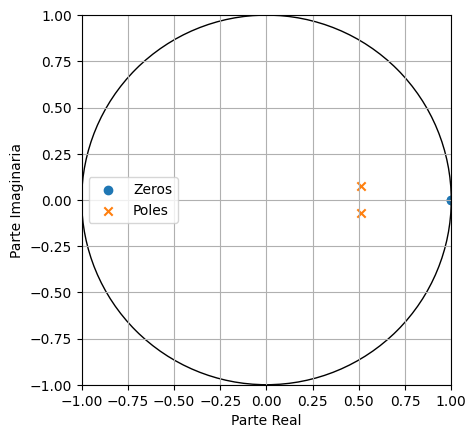

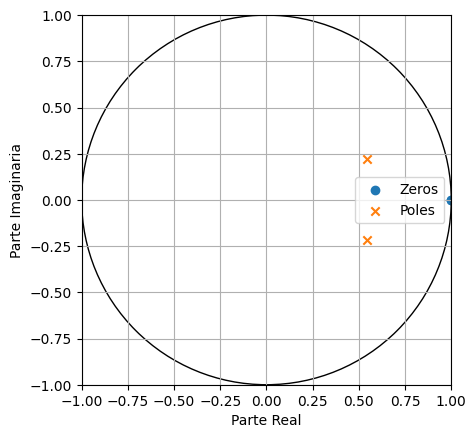

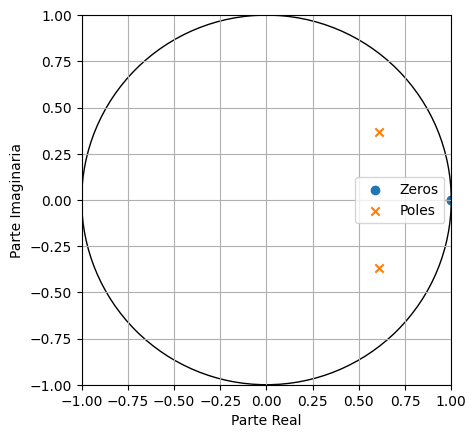

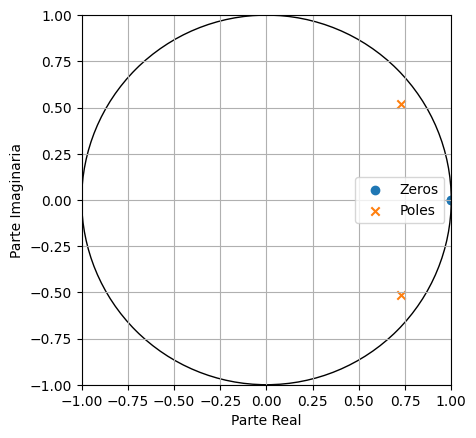

In [3]:
# Ejemplo 5.2 (Parte B). Ubicación de los polos y ceros de cada etapa
# La función zplane es la misma del Ejemplo 5.1
for stage in sos:
    sys = sig.TransferFunction(stage[0:3], stage[3:6], dt=0.1)
    zplane(sys)

#### Para Reflexionar

* Adapte el programa de referencia https://wokwi.com/projects/408470883234121729 para implementar el filtro IIR con la estructura en cascada. Recuerde que cada etapa en cascada se implementa con alguna estructura como la tipo II o III. En particular, se sugiere que haga sus modificaciones usando la estructura tipo II, ya que el programa de referencia implementa un filtro IIR con estructura tipo II de orden $N$.

* Obtenga los coeficientes en cascada de la función de transferencia de una curva de ponderación A (A-weighting). Esta curva se emplea en el diseño de sistemas de medición de la potencia sonora. Como referencia para la función de transferencia de la curva A consulte https://en.wikipedia.org/wiki/A-weighting 

## 5.5 Efecto de las Condiciones Iniciales

En un filtro FIR, los valores iniciales de las entradas $x[n]$ no tienen ningún efecto sobre la respuesta en frecuencia del sistema, lo único que introducen es un transitorio durante el arranque del sistema. En cambio para los sistemas IIR, por su carácter recursivo, las condiciones iniciales de la salida y ($y[-1]$, $y[-2]$, etc.) si son determinantes e influyen decididamente sobre la respuesta en frecuencia. Únicamente con condiciones iniciales cero es posible garantizar que el sistema tenga una respuesta en frecuencia igual a la diseñada y sea estable.

Para apreciar mejor lo comentado anteriormente, tomemos como ejemplo la ecuación en diferencias: $$y[n]-Cy[n-1]=x[n]$$

Para analizar el efecto de las condiciones iniciales sobre la respuesta en frecuencia es necesario emplear la transformada $z$ unilateral. Mientras que en la transformada $z$ bilateral, la propiedad de desplazamiento en el tiempo establece que 

$$x[n-n_{0}]\Longrightarrow z^{-n_{0}}X(z)$$

en la transformada $z$ unilateral se tiene que 

$$x[n-n_{0}]\Longrightarrow z^{-n_{0}}\left\{ X(z)-\sum_{a=1}^{n_{0}}x[-a]z^{a}\right\}$$

luego, aplicando la transformada $z$ unilateral a la ecuación en diferencias se obtiene:

$$Y(z)-Cz^{-1}\left\{ Y(z)-y[-1]z\right\} =X(z)$$

$$Y(z)=\frac{X(z)+Cy[-1]}{1-Cz^{-1}}$$

Solamente cuando las condiciones iniciales son cero ($y[-1]=0$) y aplicamos una función impulso a la entrada ($x[n]=\delta[n]\rightarrow X(z)=1$), el espectro en frecuencia de la salida será la función de transferencia $H(z)$ y en el dominio del tiempo obtenemos la respuesta al impulso del sistema. 

Esto no es cierto si las condiciones iniciales son diferentes de cero. Por ejemplo, supongamos que $y[-1]=-1/C$. Al aplicar la función impulso a la entrada, el espectro en frecuencias de la salida será $Y(z)=0$, lo que en el tiempo se verá reflejado como una ausencia de señal. Algo similar ocurre para cualquier otro tipo de señal de entrada y un valor diferente de cero para la condición inicial $y[-1]$.

## 5.6. Estructura en Celosía

Dado que la estabilidad de los filtros IIR depende exclusivamente de los coeficientes $a_{k}$, es necesario emplear estrategias que garanticen la estabilidad de la implementación. Ya se mostró una estructura que permite hacerlo, la estructura en cascada, pero hay otra forma de abordar el problema y es la **Estructura en Celosía**, o **_Lattice_** en inglés.

La función de transferencia de un filtro digital $H(z)$ se puede expandir en dos filtros conectados en serie:

$$H(z)=\frac{B(z)}{A(z)}=B(z)\frac{1}{A(z)}$$

donde el filtro $\frac{1}{A(z)}$ es un filtro todo-polos que es el responsable de la estabilidad del sistema.

La estructura de este filtro todo-polos se puede reescribir a través de los coeficientes de reflexión, $K_{m}$, de la forma mostrada a continuación para un orden $N=2$.

![Estructura en Celosía](../img/cap5_celosia.png)

La forma como se deriva esta estructura no se abordará en este documento pues hace parte de técnicas de análisis estadístico de señales. 

La principal ventaja de esta estructura es que si los coeficientes de reflexión cumplen la condición

$$|K_{m}|<1$$

el filtro es estable. Esta condición garantiza que la cuantización de los coeficientes sea fácil de realizar, se reduce el error de cuantización, y se puedan construir filtros IIR configurables.

A continuación, se muestran las ecuaciones empleadas en el cálculo de los coeficientes de reflexión, $K_{m}$ a partir de los coeficientes $a_{k}$, y viceversa. Estas ecuaciones se derivan de un algoritmo conocido como Levinson-Durbin, e implican cálculos recursivos.

1. **Conversión estructura directa a rejilla**. Las siguientes ecuaciones se repiten para $m = P, P-1, P-2,...1$:

$$\begin{array}{ll}
K_{m}=a_{m}(m) \\
a_{m-1}(k)=\frac{a_{m}(k)-a_{m}(m) a_{m}(m-k)}{1-|a_{m}(m)|^2} & k=1,2,...,m-1 \\
\end{array}$$

2. **Conversión estructura rejilla a directa**. Las siguientes ecuaciones se repiten para $m = 1, 2, 3, ... , P$:

$$\begin{array}{ll}
a_{m}(0)=1 \\
a_{m}(m)=K_{m} \\
a_{m}(k)=a_{m-1}(k)-K_{m} a_{m-1}(m-k) & k=1,2,...,m-1 \\
\end{array}$$ 

El ejemplo a continuación muestra como calcular los coeficientes de reflexión empleando las ecuaciones anteriores. Nótese en el ejemplo que se retornan $N$ coeficientes cuyos valores están entre -1 y 1; asimismo, $K_{0}=1$ no se emplea en el diagrama de la estructura.

In [4]:
# Ejemplo 5.3. Cálculo de los coeficientes de reflexión de un filtro pasa-altos Butterworth de 8to orden
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

bk,ak = sig.butter(8, 0.2, 'highpass')

def tf2latc(ak):
    P = len(ak)
    Km = np.zeros(P)
    am = ak
    for m in range(P,0,-1):
        Km[m-1] = am[m-1]
        am_1 = np.zeros(m-1)
        for k in range(1,m):
            am_1[k-1] = (am[k-1] - am[m-1]*am[m-k])/(1-np.power(np.abs(am[m-1]),2))
        am = am_1
    return Km

Km = tf2latc(ak)
print(Km)   

[ 1.         -0.91414402  0.94016713 -0.9207987   0.88736218 -0.8026325
  0.58242224 -0.23956424  0.0372001 ]


#### Para Reflexionar

* Note que el procedimiento de conversión a celosía se aplica solamente a la componente todo-polos de la función de transferencia. ¿Cómo se tendría que implementar $B(z)$? ¿Esta componente sufre de problemas de cuantización?
* Modifique el algoritmo de referencia para implementar el filtro digital en estructura en Celosía.